In [150]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from torch import optim
import torch
from torch import nn

from torchtext import data
from torch.nn import functional as F
from fastai.nlp import LanguageModelData, ConcatTextDatasetFromDataFrames
from fastai.lm_rnn import seq2seq_reg
from fastai.metrics import accuracy
from fastai.core import V
from fastai.learner import fit
from fastai.column_data import ColumnarModelData
from fastai.core import T, VV, to_np
from fastai.dataset import get_cv_idxs
from fastai.layer_optimizer import set_lrs

In [2]:
# !pip install spacy

In [3]:
# !python -m spacy download en

## Load and prepare dataset

In [4]:
df = pd.read_csv('./data/raw/global_warming_tweets.csv', encoding='latin1')

In [5]:
df.existence.value_counts(dropna=False)

Y      2554
NaN    1865
N      1053
Yes     557
No       61
Name: existence, dtype: int64

In [6]:
df.head()

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087


In [7]:
df.existence = df.existence.replace({'Yes': 'Y', 'No': 'N', pd.np.nan: 'O'})

In [8]:
df.existence.value_counts(dropna=False)

Y    3111
O    1865
N    1114
Name: existence, dtype: int64

In [9]:
df = df.sample(frac=1., random_state=42)

In [10]:
len(df)

6090

In [11]:
texts = df.tweet.tolist()

In [12]:
texts_str = ' '.join(texts)

In [14]:
texts_str[:80]

'RT @patrickc: "The very idea that they care more about safety than we do is as s'

In [15]:
chars = sorted(list(set(texts_str)))

In [16]:
chars[:5]

['\t', ' ', '!', '"', '#']

Add value for padding:

In [17]:
chars.insert(0, "\0")

In [18]:
''.join(chars[1:-6])

'\t !"#$%&\'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x95£´»ÀÁ'

Map from chars to indices and back again.

In [19]:
chars_to_indices = {}
for idx, char in enumerate(chars):
    chars_to_indices[char] = idx

In [20]:
idx_to_chars = {idx: char  for char, idx in chars_to_indices.items()}

In [21]:
chars_to_indices['w']

87

In [22]:
idx_to_chars[87]

'w'

In [23]:
idx = [chars_to_indices[c] for c in texts_str]

In [24]:
idx[:10]

[50, 52, 2, 32, 80, 65, 84, 82, 73, 67]

In [25]:
''.join(idx_to_chars[i] for i in idx[:70])

'RT @patrickc: "The very idea that they care more about safety than we '

In [26]:
vocab_size = len(chars) + 1

In [27]:
print("total chars:", vocab_size)

total chars: 108


Character level models can be useful for certain tasks, especially in language translation models: if you find an unknown word, pass to character level models.

In [28]:
cs = 3
c1_dat = [idx[i] for i in range(0, len(idx) - 1 - cs, cs)]
c2_dat = [idx[i+1] for i in range(0, len(idx) - 1 - cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx) - 1 - cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx) - 1 - cs, cs)]

In [29]:
c1_dat[:10]

[50, 32, 84, 67, 28, 52, 2, 82, 73, 65]

In [30]:
''.join(idx_to_chars[i] for i in c1_dat[:70])

'R@tc:T riah eceo o fyh     l  olai.-aeEr 9e nsGb rnoumoe.co uo st?BM c'

In [31]:
''.join(idx_to_chars[i] for i in c2_dat[:70])

'Tprk hvyd atya rause awdiaslagb rn" syng( ame)lawmgrnpyn.hsyrwdae:yaJo'

In [32]:
''.join(idx_to_chars[i] for i in c3_dat[:70])

' aic"ee etth rmebtattneossiyslawmg Ms ey2ddir olai  elmt.oeo nisr  xab'

In [33]:
''.join(idx_to_chars[i] for i in c4_dat[:70])

'@tc:T riah eceo o fyh     l  olai.-aeEr 9e nsGb rnoumoe.co uo st?BM cs'

Inputs:

In [34]:
x1 = np.stack(c1_dat[:-2])
x2 = np.stack(c2_dat[:-2])
x3 = np.stack(c3_dat[:-2])

In [35]:
x1[:10]

array([50, 32, 84, 67, 28, 52,  2, 82, 73, 65])

In [36]:
y = np.stack(c4_dat[:-2])

The first 4 inputs and outputs:

In [37]:
x1[:4], x2[:4], x3[:4]

(array([50, 32, 84, 67]), array([52, 80, 82, 75]), array([ 2, 65, 73, 67]))

In [38]:
y[:4]

array([32, 84, 67, 28])

In [39]:
x1.shape, y.shape

((226882,), (226882,))

## Build char model (non RNN)

In [49]:
num_factors = 42
num_hidden_activations = 256

In [55]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, embedding_width):
        super().__init__()
        self.emb_layer = nn.Embedding(vocab_size, embedding_width)
        
        self.input_layer = nn.Linear(embedding_width, num_hidden_activations)
        
        self.hidden_layer = nn.Linear(num_hidden_activations, num_hidden_activations)
        
        self.output_layer = nn.Linear(num_hidden_activations, vocab_size)
        
    def forward(self, char_1, char_2, char_3):
        # Get first input activations
        input_1 = F.relu(self.input_layer(self.emb_layer(char_1)))
        hidden = F.tanh(self.hidden_layer(input_1))
        
        # Get activations from 2nd layer
        input_2 =  F.relu(self.input_layer(self.emb_layer(char_2)))
        hidden = F.tanh(self.hidden_layer(hidden + input_2))
        
        # Now third
        input_3 = F.relu(self.input_layer(self.emb_layer(char_3)))
        hidden = F.tanh(self.hidden_layer(hidden + input_3))
        
        return F.log_softmax(self.output_layer(hidden))

In [56]:
np.stack([x1, x2, x3], axis=1).shape

(226882, 3)

In [57]:
y.shape

(226882,)

In [58]:
model_data = ColumnarModelData.from_arrays(
    path=Path('.'),
    val_idxs=[-1],
    xs=np.stack([x1, x2, x3], axis=1),
    y=y, bs=512)

In [59]:
model = Char3Model(vocab_size, num_factors)

In [60]:
opt = optim.Adam(model.parameters(), 1e-3)

In [75]:
fit(model, model_data, 5, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.771089   0.980628  
    1      1.741405   0.739312                              
    2      1.715492   0.478331                              
    3      1.703063   0.457567                              
    4      1.698206   0.342634                              



[array([0.34263])]

Let's test it:

In [76]:
def get_next(inp):
    idxs = T(np.array([chars_to_indices[c] for c in inp]))
    probs = model(*VV(idxs))
    i = np.argmax(to_np(probs))
    return chars[i]

In [77]:
get_next('glo')

'b'

In [78]:
get_next('war')

'm'

In [79]:
# war min g
get_next('min')

'g'

### First RNN

In [80]:
cs = 8

For each of 0 through 7, create a list of every 8th character with that starting point. These will be the 8 inputs to our model.

In [95]:
c_in_dat = []

for i in range(len(idx) - cs):
    c = []
    
    for j in range(cs):
        c.append(idx[i + j])
        
    c_in_dat.append(c)

In [96]:
c_in_dat[:10]

[[50, 52, 2, 32, 80, 65, 84, 82],
 [52, 2, 32, 80, 65, 84, 82, 73],
 [2, 32, 80, 65, 84, 82, 73, 67],
 [32, 80, 65, 84, 82, 73, 67, 75],
 [80, 65, 84, 82, 73, 67, 75, 67],
 [65, 84, 82, 73, 67, 75, 67, 28],
 [84, 82, 73, 67, 75, 67, 28, 2],
 [82, 73, 67, 75, 67, 28, 2, 4],
 [73, 67, 75, 67, 28, 2, 4, 52],
 [67, 75, 67, 28, 2, 4, 52, 72]]

Create a list of the next character in each of these series. This will be the labels for our model.

In [84]:
c_out_dat = [idx[j+cs] for j in range(len(idx)-cs)]

In [85]:
xs = np.stack(c_in_dat, axis=0)

In [87]:
xs.shape

(680646, 8)

In [88]:
y = np.stack(c_out_dat)

In [131]:
xs[:cs, :cs]

array([[50, 52,  2, 32, 80, 65, 84, 82],
       [52,  2, 32, 80, 65, 84, 82, 73],
       [ 2, 32, 80, 65, 84, 82, 73, 67],
       [32, 80, 65, 84, 82, 73, 67, 75],
       [80, 65, 84, 82, 73, 67, 75, 67],
       [65, 84, 82, 73, 67, 75, 67, 28],
       [84, 82, 73, 67, 75, 67, 28,  2],
       [82, 73, 67, 75, 67, 28,  2,  4]])

and the next character after each sequence

In [90]:
y[:cs]

array([73, 67, 75, 67, 28,  2,  4, 52])

### Create and train model

In [128]:
model_data = ColumnarModelData.from_arrays('.', [-1], xs, y, bs=512, shuffle=False)

In [129]:
batch = next(iter(model_data.trn_dl))

Confirm that without shuffle and without a validation set, the first column matches and column above and so on.

In [132]:
batch[0][:5]


 50
 52
  2
 32
 80
[torch.LongTensor of size 5]

In [134]:
batch[1][:5]


 52
  2
 32
 80
 65
[torch.LongTensor of size 5]

In [135]:
val_idx = get_cv_idxs(len(idx) - cs - 1)

In [136]:
model_data = ColumnarModelData.from_arrays('.', [-1], xs, y, bs=512, shuffle=False)

In [145]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, n_fac)
        self.linear_input = nn.Linear(n_fac, num_hidden_activations)
        self.linear_hidden = nn.Linear(num_hidden_activations, num_hidden_activations)
        self.linear_output = nn.Linear(num_hidden_activations, vocab_size)
        
    def forward(self, *chars):
        # Get batch size from first column
        batch_size = chars[0].size(0)
        
        # Init hidden state to all 0s
        h = V(torch.zeros(batch_size, num_hidden_activations))
        
        for char in chars:
            inp = F.relu(self.linear_input(self.embeddings(char)))
            h = F.tanh(self.linear_hidden(h + inp))
            
        return F.log_softmax(self.linear_output(h), dim=-1)

In [146]:
model = CharLoopModel(vocab_size, num_factors)

In [147]:
opt = optim.Adam(model.parameters(), 1e-2)

In [148]:
fit(model, model_data, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      2.151497   0.039983  



[array([0.03998])]

In [151]:
set_lrs(opt, 0.001)

In [152]:
fit(model, model_data, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.835437   0.0112    



[array([0.0112])]

In [166]:
def get_next(inp):
    idxs = T(np.array([chars_to_indices[c] for c in inp]))
    probs = model(*VV(idxs))
    i = np.argmax(to_np(probs))
    return chars[i]

In [167]:
get_next('global warmin')

'g'

In [168]:
get_next('climate chan')

'g'

In [169]:
get_next('is a hoa')

'x'

In [170]:
get_next('scientific consensu')

's'

### Concat model

The input state and the hidden state are qualitatively different. Input is the encoding of a character, and h is an encoding of series of characters. So adding them together, we might lose information. Let’s concatenate them instead. Don’t forget to change the input to match the shape (n_fac+n_hidden instead of n_fac).

In [190]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, emb_size, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.input_layer = nn.Linear(n_hidden + emb_size, n_hidden)
        self.hidden_layer = nn.Linear(n_hidden, n_hidden)
        self.output_layer = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *chars):
        batch_size = chars[0].size(0)
        hidden = V(torch.zeros(batch_size, self.n_hidden))

        for char in chars:
            char_emb = self.embedding(char)
            
            # Concat along columns
            inp = torch.cat((hidden, char_emb), 1)
            
            inp = F.relu(self.input_layer(inp))
    
            hidden = F.tanh(self.hidden_layer(inp))
        
        return F.log_softmax(self.output_layer(hidden), dim=-1)

In [191]:
model = CharLoopConcatModel(vocab_size, num_factors, num_hidden_activations)

In [192]:
opt = optim.Adam(model.parameters(), 1e-3)

In [193]:
fit(model, model_data, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.829992   0.017843  


[array([0.01784])]

In [194]:
fit(model, model_data, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.651855   0.008019  


[array([0.00802])]

In [195]:
set_lrs(opt, 0.001)

In [196]:
fit(model, model_data, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.560111   0.011733  


[array([0.01173])]

In [197]:
def get_next(inp):
    idxs = T(np.array([chars_to_indices[c] for c in inp]))
    probs = model(*VV(idxs))
    i = np.argmax(to_np(probs))
    return chars[i]

In [198]:
get_next('global warmin')

'g'

## RNN with PyTorch

In [199]:
rnn = nn.RNN(num_factors, num_hidden_activations)

In [203]:
hidden = V(torch.zeros(1, 512, num_hidden_activations))

In [204]:
model_data = ColumnarModelData.from_arrays('.', [-1], xs, y, bs=512, shuffle=False)

In [232]:
*xs, y = next(iter(model_data.trn_dl))

In [220]:
embedding = nn.Embedding(vocab_size, num_factors)

In [221]:
inp_var = V(torch.stack(xs))

In [222]:
inp_var.shape

torch.Size([8, 512])

In [223]:
[i.shape for i in inp_var]

[torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512])]

In [224]:
inp = embedding(inp_var)

In [227]:
inp.shape

torch.Size([8, 512, 42])

In [228]:
outp, h = rnn(inp, hidden)

In [229]:
outp.shape

torch.Size([8, 512, 256])

In [230]:
h.shape

torch.Size([1, 512, 256])

In [233]:
t = model(*V(xs)); t.size()

torch.Size([512, 108])

In [234]:
vocab_size

108

In [250]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden):
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, self.n_hidden)
        self.l_out = nn.Linear(self.n_hidden, vocab_size)
        
    def forward(self, *chars):
        batch_size = chars[0].size(0)
        hidden = V(torch.zeros(1, batch_size, self.n_hidden))
        inp = self.embedding(torch.stack(chars))
        outp, hidden = self.rnn(inp, hidden)

        return F.log_softmax(self.l_out(outp[-1]), dim=-1)

In [254]:
model = CharRnn(vocab_size, num_factors, num_hidden_activations)
opt = optim.Adam(model.parameters(), 1e-3)

In [252]:
t = model(*V(xs))

In [253]:
t.shape

torch.Size([512, 108])

In [255]:
fit(model, model_data, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.856666   0.018851  
    1      1.687123   0.006569                                
    2      1.597544   0.003674                                
    3      1.539042   0.002655                                


[array([0.00265])]

## Stateful RNN

It'd be ideal if the RNN could store its hidden states in between forward pass, to avoid having to relearn it from scratch each time.

In [313]:
from fastai.lm_rnn import repackage_var

In [314]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden, batch_size):
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(batch_size)
        
    def forward(self, cs):
        batch_size = cs[0].size(0)
        if self.h.size(1) != batch_size:
            self.init_hidden(batch_size)

        outp, h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = V(torch.zeros(1, bs, self.n_hidden))

In [315]:
from torchtext import data

In [316]:
TEXT = data.Field(lower=True, tokenize=list)

In [317]:
bs = 64
bptt = 8
n_fac = 42
n_hidden = 256

In [318]:
len(df)

6090

In [319]:
train_df = df[:5000]
val_df = df[5000:]

In [320]:
train_df.existence.value_counts()

Y    2541
O    1532
N     927
Name: existence, dtype: int64

In [321]:
val_df.existence.value_counts()

Y    570
O    333
N    187
Name: existence, dtype: int64

In [322]:
PATH = Path('./data/tmp')

In [323]:
model_data = LanguageModelData.from_dataframes(PATH, TEXT, 'tweet', train_df=train_df, val_df=val_df, bs=bs, bptt=bptt)

In [324]:
len(model_data.trn_dl)

1145

In [325]:
trn_dl_iter = iter(model_data.trn_dl)

In [326]:
xs, y = next(trn_dl_iter)

In [327]:
xs.shape

torch.Size([17, 64])

In [328]:
xs, y = next(trn_dl_iter)

In [329]:
xs.shape

torch.Size([11, 64])

The sequence length is different for each mini batch. Makes sense: that part can be anything.

In [330]:
model = CharSeqStatefulRnn(vocab_size, num_factors, num_hidden_activations, 512)
opt = optim.Adam(model.parameters(), 1e-3)

In [331]:
fit(model, model_data, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                                
    0      1.716935   1.717919  


[array([1.71792])]

In [174]:
embedding_layer = nn.Embedding(vocab_size, embedding_width)

In [158]:
# emb_data = embedding_layer(char_1)

In [176]:
PATH = Path('./data/tmp')
PATH.mkdir(exist_ok=True)

In [177]:
model_data = LanguageModelData.from_dataframes(PATH, FIELD, 'tweet', train_df, val_df, test_df=test_df)

Number of batches:

In [178]:
len(model_data.trn_dl)

18

Num unique tokens in vocab

In [47]:
model_data.nt

10476

Number of sentenecs

In [49]:
len(model_data.trn_ds[0].text)

89166

In [54]:
FIELD.vocab.itos[:10]

['<unk>',
 '<pad>',
 '<',
 '>',
 'eos',
 ':',
 'climate',
 'change',
 'global',
 'warming']

In [63]:
em_sz = 20  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [64]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [65]:
learner = model_data.get_model(
    opt_fn, em_sz, nh, nl,
    dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [66]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      7.490637   6.749711  
    1      6.938184   6.199966                            
    2      6.503571   6.128257                            
    3      6.27187    5.856059                            
    4      6.004722   5.699789                            
    5      5.777897   5.63743                             
    6      5.611077   5.609128                            
  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [123]:
TEXT_FIELD = data.Field(lower=True, tokenize="spacy")
LABEL_FIELD = data.Field(sequential=False)

In [124]:
from torchtext.data import TabularDataset

In [125]:
from fastai.nlp import TextData

In [126]:
class MyDataset(data.Dataset):
    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.existence
            text = row.tweet
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [127]:
len(train_df)

4000

In [128]:
train_ds, val_ds, test_ds = MyDataset.splits(
    text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=train_df,
    val_df=val_df, test_df=test_df)

In [129]:
TEXT_FIELD.build_vocab(train_ds)

In [130]:
TEXT_FIELD.vocab.itos[:20]

['<unk>',
 '<pad>',
 ':',
 'global',
 'climate',
 'warming',
 'change',
 'the',
 '#',
 ',',
 'to',
 '.',
 'of',
 '-',
 '...',
 'is',
 'in',
 'a',
 'rt',
 'and']

In [131]:
text_data = TextData.from_splits(PATH, (train_ds, val_ds, test_ds), bs=bs, text_name='text', label_name='label')

In [132]:
m3 = text_data.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.65, wdrop=0.5, dropoute=0.1, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.clip=25.

In [133]:
m3.lr_find()

 75%|███████▍  | 47/63 [00:00<00:00, 60.86it/s, loss=0.817]


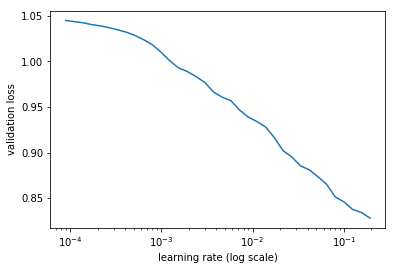

In [134]:
m3.sched.plot()

In [135]:
m3.unfreeze()

In [138]:
m3.fit(0.001, 1, metrics=[accuracy], cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.231975   0.629368   0.742811  



[array([0.62937]), 0.7428111824938046]

In [139]:
m3.fit(0.001, 3, metrics=[accuracy], cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.232341   0.649829   0.738611  
    1      0.219688   0.631224   0.74886                   
    2      0.216479   0.616329   0.748188                  
    3      0.212528   0.587296   0.768201                  
    4      0.204572   0.62905    0.742811                  
    5      0.194663   0.546126   0.751054                  
    6      0.194686   0.555985   0.745499                  



[array([0.55599]), 0.7454993545368154]

In [140]:
m3.fit(0.0001, 5, metrics=[accuracy], cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.18386    0.572231   0.760126  
    1      0.180652   0.567026   0.756766                  
    2      0.176712   0.577256   0.741299                  
    3      0.170845   0.571548   0.760126                  
    4      0.176119   0.582053   0.760126                  
    5      0.172678   0.585166   0.759454                  
    6      0.189165   0.567799   0.759454                  
    7      0.183714   0.587814   0.7497                    
    8      0.16755    0.572012   0.759454                  
    9      0.170211   0.571712   0.759454                  
    10     0.170893   0.607364   0.745499                  
    11     0.168933   0.590727   0.758614                  
    12     0.17155    0.57149    0.759454                  
    13     0.17383    0.596397   0.772401                  
    14     0.173112   0.591352   0.759454                  
    15     0.170239   0.615794   0.769713               

[array([0.58042]), 0.7560942044822119]

In [108]:
splits[0].examples[10].text

['@climate',
 'change',
 'giant',
 '#',
 'glacier',
 'fall',
 'in',
 'peru',
 'causes',
 'deadly',
 'tsunami',
 ':',
 'http://bit.ly/bvg95c']